[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gabays/32M7131/blob/main/Cours_06/Cours_06.ipynb)

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Licence Creative Commons" style="border-width:0;float:right;\" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>

Distant Reading 2: linguistique computationnelle

# Les tâches de classification

Simon Gabay


## Préparation de l'expérience
Nous devons récupérer:
- des _embeddings_
- un corpus de travail pour la classification

### Embbedings

On télécharge des embeddings

In [ ]:
!pip install gensim==4.2
import gensim
print(gensim.__version__)
from gensim.models import KeyedVectors
!wget https://embeddings.net/embeddings/frWiki_no_lem_no_postag_no_phrase_1000_cbow_cut100.bin
MyModel = KeyedVectors.load_word2vec_format("/content/frWiki_no_lem_no_postag_no_phrase_1000_cbow_cut100.bin", binary=True)
MyModel.most_similar("intéressant")

### Corpus

In [2]:
#On le récupère en ligne
!rm ComTra.tsv
!wget https://raw.githubusercontent.com/gabays/32M7131/main/Cours_05/ComTra.tsv

rm: cannot remove 'ComTra.tsv': No such file or directory
--2023-04-17 15:47:23--  https://raw.githubusercontent.com/gabays/32M7131/main/Cours_05/ComTra.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771418 (753K) [text/plain]
Saving to: ‘ComTra.tsv’

ComTra.tsv          100%[===================>] 753.34K  --.-KB/s    in 0.04s   

2023-04-17 15:47:23 (16.7 MB/s) - ‘ComTra.tsv’ saved [771418/771418]



Les comédies commencent par `1`

In [3]:
!head ComTra.tsv

1	Chrysalde, Vous venez, dites-vous, pour lui donner la main ?
1	Oui, je veux terminer la chose dans demain.
1	Nous sommes ici seuls ; et l'on peut, ce me semble,
1	Sans craindre d'être ouïs, y discourir ensemble.
1	Voulez-vous qu'en ami je vous ouvre mon coeur ?
1	Votre dessein pour vous me fait trembler de peur ;
1	Et de quelque façon que vous tourniez l'affaire,
1	Prendre femme, est à vous un coup bien téméraire.
1	Il est vrai, notre ami. Peut-être que chez vous
1	Vous trouvez des sujets de craindre pour chez nous ;


Les tragédies par `0`:

In [4]:
!tail ComTra.tsv

0	Par des noeuds éternels l'un à l'autre nous lie.
0	Nous, Seigneur ?
0	Quoi, Madame ! osez-vous balancer ?
0	Et ne m'avez-vous pas défendu d'y penser ?
0	J'eus mes raisons alors. Oublions-les, Madame. 
0	Ne songez maintenant qu'à répondre à ma flamme. 
0	Songez que votre coeur est un bien qui m'est dû.
0	Hé pourquoi donc, Seigneur, me l'avez-vous rendu ?
0	Quoi ! pour un fils ingrat toujours préoccupée
0	Vous croiriez...

Nous importons notre jeu de données pour l'entrainement.

In [5]:
import pandas as pd
comTra = pd.read_csv('/content/ComTra.tsv', sep='\t', header = None)
comTra.head()

,0,1
0,1,"Chrysalde, Vous venez, dites-vous, pour lui do..."
1,1,"Oui, je veux terminer la chose dans demain."
2,1,"Nous sommes ici seuls ; et l'on peut, ce me se..."
3,1,"Sans craindre d'être ouïs, y discourir ensemble."
4,1,Voulez-vous qu'en ami je vous ouvre mon coeur ?


On renomme les colonnes

In [6]:
comTra.rename(columns={0:'Genre', 1:'Texte'}, inplace=True)
comTra.head()

,Genre,Texte
0,1,"Chrysalde, Vous venez, dites-vous, pour lui do..."
1,1,"Oui, je veux terminer la chose dans demain."
2,1,"Nous sommes ici seuls ; et l'on peut, ce me se..."
3,1,"Sans craindre d'être ouïs, y discourir ensemble."
4,1,Voulez-vous qu'en ami je vous ouvre mon coeur ?


On va un peu mélanger les lignes, sinon on va avoir toutes les comédies à la suite, puis toutes les tragédies.

In [7]:
comTra = comTra.sample(frac=1).reset_index(drop=True)
comTra.head()

,Genre,Texte
0,1,Mon Dieu !
1,0,"Fuyez, Hémon, fuyez de la fille d'Oedipe,"
2,1,Et ne porte le noir qu'aux bons jours seulement.
3,1,"Ce langage, il est vrai, peut être obscur parf..."
4,1,Souvent nous avons peine à dire pourquoi c'est.


## Intégration des _embeddings_

On prépare les données (on récupère les vecteurs de chaque mot s'ils ne sont pas des _stopwords_ et on fait la moyenne pour chaque extrait).

⚠️ Il y a une ligne à changer si vous utilisez un modèle créé avec Gensim. Elle est indiquée.

⚠️ Compter environ 5mn

In [ ]:
import nltk
#On télécharge la liste des stopwords
nltk.download('stopwords')

#On crée un dataframe vide pour stocker les résultats
docs_vectors = pd.DataFrame()
#On retire les stopwords du français
stopwords = nltk.corpus.stopwords.words('french')
#on passe en revue tous les textes que l'on nettoie
for doc in comTra['Texte'].str.lower().str.replace('[^a-z ]', ''):
    # On crée un dataframe temporaire # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
    temp = pd.DataFrame()  
    #On tokenize à la va vite avec les espaces
    for word in doc.split(' '):
      #Si le mot n'est pas dans la liste des stopwords
        if word not in stopwords: 
            try:
              # si le mot est présent dans les embeddings alors on continue
                word_vec = MyModel[word] 
                # Commenter la ligne précédente et utiliser cette ligne si le modèle est créé avec gensim:
                #word_vec = MyModel.wv[word] 
                # on l'ajoute au dataframe
                temp = temp.append(pd.Series(word_vec), ignore_index = True) 
                #Sinon on ne fait rien
            except:
                pass
    # on fait la moyenne de chaque colonne (w0, w1, w2,........w300)
    doc_vector = temp.mean() 
    # On ajoute la valeur de chaque document au dataframe final 
    docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) 
docs_vectors.shape

On nettoie le _dataframe_ si des valeurs sont absentes (_null_)

In [30]:
pd.isnull(docs_vectors).sum().sum()

648000

On nettoie le _dataframe_ si des valeurs sont absentes (_NA_, pour _not available_).


In [31]:
docs_vectors['Genre'] = comTra['Genre']
docs_vectors = docs_vectors.dropna()

## Classification

Il faut d'abord préparer les données de _train_ et de _test_:

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

train_x, test_x, train_y, test_y = train_test_split(docs_vectors.drop('Genre', axis = 1), #x axis
                                                   docs_vectors['Genre'], #y axis
                                                   test_size = 0.2,#20% servent pour le test
                                                   random_state = 1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((12040, 1000), (12040,), (3010, 1000), (3010,))

### Un premier modèle: la forêt d'arbres décisionnels

cf. [wikipedia](https://fr.wikipedia.org/wiki/For%C3%AAt_d%27arbres_d%C3%A9cisionnels)

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(train_x, train_y)

RandomForestClassifier()

On regarde la qualité du modèle. D'abord on récupère les prédictions sur le test

In [34]:
pred_y = rf.predict(test_x)

On peut sortir l'_accuracy_:

In [35]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_y, pred_y)
print("Accuracy:", accuracy)

Accuracy: 0.7498338870431893


Nous pouvons regarder à quoi ressemble les arbres (ici les trois premiers avec une profondeur de 2):

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=train_x.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

### Hyperparamètres

Nous avons précédemment utilisé les hyperparamètres par défaut. Il serait mieux de chercher les meilleurs hyperparamètres. `RandomizedSearchCV()` permet d'entraîner une multitude de modèles et ainsi de déterminer la meilleure configuration:
- `n_jobs` est un paramètre technique qui permet de sélectionner un maximum de processeurs pour le job;
- `n_iter` permet de déterminer le nombre de paramètre testés.
Il existe une fonction `GridSearchCV` qui permet de tester tous les paramètres possibles


Nous avons deux hyperparamètres à utiliser (il en existe d'autres)
- `n_estimators` est le nombre d'arbres utilisés dans la forêt: on va comparer les résultats de chacun des arbres pourproposer une prédiction finale. Augmenter ce paramètre permet d'affiner le résultat, mais augmente le temps de calcul. La valeur dépend des performances de la machine et la valeur par défaut est 50;
- `max_depth` permet de décider de la profondeur de chaque arbre (le nombre de fois qu'il va être splité). Une valeur trop élevée peut provoquer un sur-entraînement, l'inverse un sous-entraînement.

In [49]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'n_estimators': randint(50,60),# On pourrait tester ici 50,500
              'max_depth': randint(1,5)}#On pourrait tester ici 1,20

# On crée une forêt d'arbres décisionnels
rf = RandomForestClassifier()

# Recherche aléatoire des meilleurs paramètres
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_jobs = -1,
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(train_x, train_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f44279ee6d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f442823ea00>})

On affiche les meilleurs paramètres:

In [50]:
# On crée une variable pour le meilleur modèle
best_rf = rand_search.best_estimator_

# On affiche les hyperparamètres
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 5, 'n_estimators': 53}


### Métriques

La simple _accuracy_ peut paraître un peu imprécise. Tentons de construire une matrice de confusion pour regarder le nombre d'erreurs:

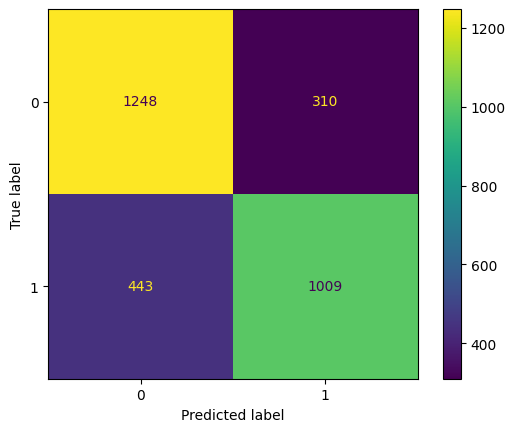

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions with the best model
y_pred = best_rf.predict(test_x)

# Create the confusion matrix
cm = confusion_matrix(test_y, pred_y)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [52]:
from sklearn.metrics import precision_score, recall_score

pred_y = best_rf.predict(test_x)

accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7498338870431893
Precision: 0.7649734647460197
Recall: 0.6949035812672176


Nous pouvons afficher tout cela sous une autre forme:

In [54]:
from sklearn.metrics import classification_report

predictions = best_rf.predict(test_x) 
print(classification_report(test_y, predictions)) 

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      1558
           1       0.69      0.56      0.62      1452

    accuracy                           0.67      3010
   macro avg       0.67      0.66      0.66      3010
weighted avg       0.67      0.67      0.66      3010



## D'autres méthodes

### `AdaBoost`

`AdaBoost` est un méta-algorithme de _boosting_, utilisé en association avec d'autres types d'algorithme, comme la forêt d'arbres décisionnels.

cf. [wikipedia](https://fr.wikipedia.org/wiki/AdaBoost)

Les paramètres possibles sont: 
- `base_estimator` qui permet de sélectionner le type de classifieur. C'est par défaut une forêt d'arbres décisionnels;
- `n_estimators` permet de décider le nombre de modèles à entraîner

⚠️ Cela va prendre beaucoup plus de temps que sans `AdaBoost`: compter plus de 4h20 avec les mêmes paramètres que précédemment… (alors que ça avait pris quelques minutes).

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

param_dist = {'n_estimators': randint(50,60)}
base_model = RandomForestClassifier()#On pourrait passer des hyperparamètres entre les parenthèses
#On pourrait importer ici d'autres types de classifieurs. Il suffit de les importer avec sklearn, comme un SVC
#from sklearn.svm import SVC
#base_model=SVC(probability=True, kernel='linear')

# On crée une forêt d'arbres décisionnels avec AdaBoost
abc = AdaBoostClassifier(base_estimator=base_model)

# Recherche aléatoire des meilleurs paramètres
rand_search_abc = RandomizedSearchCV(abc, 
                                 param_distributions = param_dist, 
                                 n_jobs = -1,
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search_abc.fit(train_x, train_y)

On affiche les meilleurs paramètres:

In [ ]:
# On crée une variable pour le meilleur modèle
best_abc = rand_search_abc.best_estimator_

# On affiche les hyperparamètres
print('Best hyperparameters:',  rand_search_abc.best_params_)

Regardons les résultats:

In [ ]:
predictions = best_abc.predict(test_x) 
print(classification_report(test_y, predictions)) 

### Machines à vecteurs de supports

On parle aussi de séparateurs à vaste marge (SVM)

Les paramètres sont:
- `C`: constante de régularisation (C) qui permet de contrôler la marge (ou l'erreur). La régularisation est d'autant plus forte que C est proche de 0
- `kernel` est le type de noyau utilisé
- `gamma` est le paramètre d’échelle du noyau (γ) pour un noyau RBF. Si le paramètre a une valeur trop petite on est en situation de sous-apprentissage, si le paramètre a une valeur trop trop grande on est en situation de sur-apprentissage.

cf. [wikipedia](https://fr.wikipedia.org/wiki/Machine_%C3%A0_vecteurs_de_support)


In [ ]:
from sklearn import svm

param_dist = {'C': [0.1, 1, 10, 100, 1000], 
              'kernel': ['linear','sigmoid']} 
              

# On crée une SVM
mvs = svm.SVC()

# Recherche aléatoire des meilleurs paramètres
rand_search_mvs = RandomizedSearchCV(mvs, 
                                 param_distributions = param_dist, 
                                 n_jobs = -1,
                                 n_iter=5, 
                                 cv=5,
                                 verbose = 3)

# Fit the random search object to the data
rand_search_mvs.fit(train_x, train_y)

On affiche les meilleurs paramètres:

In [ ]:
# On crée une variable pour le meilleur modèle
best_mvs = rand_search_mvs.best_estimator_

# On affiche les hyperparamètres
print('Best hyperparameters:',  rand_search_mvs.best_params_)

Regardons les résultats:

In [ ]:
predictions = best_mvs.predict(test_x) 
print(classification_report(test_y, predictions)) 

### Méthode des k plus proches voisins

cf. [wikipedia](https://fr.wikipedia.org/wiki/M%C3%A9thode_des_k_plus_proches_voisins)

Hyperparamètre:
- `n_neighbors` permet de définir le nombre de `k` voisin.s. Doit être un `int`;
- `weights` permet d'ajouter des poids aux points;
- `metric` permet de tester différentes mesures de distance.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
              
param_dist = {'n_neighbors': randint(1,5),
              'weights' : ['uniform','distance'],
              'metric' : ['minkowski','euclidean','manhattan']}

# On crée un classifieur KNN
knn = KNeighborsClassifier()

# Recherche aléatoire des meilleurs paramètres
rand_search_knn = RandomizedSearchCV(knn, 
                                 param_distributions = param_dist, 
                                 n_jobs = -1,
                                 n_iter=5, 
                                 cv=5,
                                 verbose = 3)

# Fit the random search object to the data
rand_search_knn.fit(train_x, train_y)

On affiche les meilleurs paramètres:

In [ ]:
# On crée une variable pour le meilleur modèle
best_knn = rand_search_knn.best_estimator_

# On affiche les hyperparamètres
print('Best hyperparameters:',  rand_search_knn.best_params_)

Regardons les résultats:

In [ ]:
predictions = best_knn.predict(test_x) 
print(classification_report(test_y, predictions)) 